In [268]:
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
from uszipcode import ZipcodeSearchEngine
from geopy.geocoders import Nominatim

from plotly.offline import init_notebook_mode, iplot
from IPython.display import display, HTML

import pandas as pd
import seaborn.apionly as sns
from datetime import date, datetime
from haversine import haversine

# statistics package
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from random import randint
# packages for mapping
from mpl_toolkits.basemap import Basemap

# packages for interactive graphs
from ipywidgets import widgets, interact
from IPython.display import display
from copy import deepcopy as copy
import time
from geopy.geocoders import Nominatim

from time import sleep
import requests
import time,datetime
import os
import json
%matplotlib inline

In [2]:
findzip = ZipcodeSearchEngine()

In [4]:
historical_data = pd.read_csv('clean_train_data.csv')

In [5]:
historical_data.head()

,Unnamed: 0,day_interval,distance,dropoff_date,dropoff_datetime,dropoff_hour,dropoff_latitude,dropoff_longitude,dropoff_zipcode,fare_amount,...,surcharge,tip_amount,tolls_amount,total_amount,trip_distance,trip_time_in_secs,vendor_id,waiting_penalty,waiting_time,weather
0,186987.0,2,10.418191,2013-01-13,2013-01-13 20:58:00,20,40.793388,-73.972809,10025,27.0,...,0.5,5.5,4.8,38.3,9.06,1200,VTS,0.000000,0.000000,Rain
1,136205.0,2,0.376856,2013-01-13,2013-01-13 21:10:00,21,40.782097,-73.978867,10024,3.5,...,0.5,0.0,0.0,4.5,0.44,120,VTS,0.029670,21.362104,Rain
2,114412.0,2,0.996570,2013-01-13,2013-01-13 21:35:00,21,40.751007,-73.978104,10168,4.5,...,0.5,0.0,0.0,5.5,0.65,240,VTS,0.691434,497.832494,Rain
3,148407.0,2,4.608048,2013-01-13,2013-01-13 21:46:00,21,40.717236,-74.003563,10278,8.5,...,0.5,1.0,0.0,10.5,2.28,420,VTS,2.600077,1872.055354,Rain
4,114616.0,2,1.231572,2013-01-13,2013-01-13 22:15:00,22,40.739117,-73.987694,10010,4.5,...,0.5,1.0,0.0,6.5,0.91,180,VTS,4.437344,3194.887668,Rain


In [6]:
historical_data.keys()

Index(['Unnamed: 0', 'day_interval', 'distance', 'dropoff_date',
       'dropoff_datetime', 'dropoff_hour', 'dropoff_latitude',
       'dropoff_longitude', 'dropoff_zipcode', 'fare_amount', 'hack_license',
       'medallion', 'mta_tax', 'passenger_count', 'payment_type',
       'pickup_date', 'pickup_datetime', 'pickup_day', 'pickup_hour',
       'pickup_latitude', 'pickup_longitude', 'pickup_minute', 'pickup_time',
       'pickup_weekday', 'pickup_zipcode', 'rate_code', 'speed',
       'store_and_fwd_flag', 'surcharge', 'tip_amount', 'tolls_amount',
       'total_amount', 'trip_distance', 'trip_time_in_secs', 'vendor_id',
       'waiting_penalty', 'waiting_time', 'weather'],
      dtype='object')

## Best Revenue from Historical Data

In [7]:
best_revenue = historical_data.groupby(['hack_license','pickup_date'])['total_amount'].sum()

In [8]:
np.max(best_revenue.reset_index()['total_amount'])

1959.2000000000003

## Preprocess

In [9]:
historical_data["dropoff_minute"] = pd.to_datetime(historical_data["dropoff_datetime"]).apply(lambda x: x.minute)
historical_data["dropoff_time"] =historical_data["dropoff_hour"] + (historical_data["dropoff_minute"] / 60)

## Reinforcement Model

In [10]:
class TaxiWorld():
    def __init__(self):
        self.waiting_penalty = 5.00
        pass
                
    def getReward(self, row):
        if row['waiting_time']/3600<=2:
            return row['total_amount'] - row['waiting_time']/3600*self.waiting_penalty
        else:
            return row['total_amount']
        
    
    def set_waiting_penalty(self, penalty):
        self.waiting_penalty = penalty
        
    def getState(self):
        print('Current State')
        return self.s
    
    def setState(self, s):
        self.s = s
        
    def getStateSize(self, trip_and_fare):
        return len(trip_and_fare['zip_code'].unique())
    
    def getZipCodes(self, trip_and_fare):
        return self.zip_codes
    
    def getActionSize(self):
        return len(self.actions)

    def nextAction(self, s):
        print('Calculate Next Action based on state')
        
    def check_Q_table(self, s):
        if s not in self.Q:
            self.Q[s] = dict((action, 0.0) for action in self.actions)
            

In [11]:
env = TaxiWorld()

In [255]:
class TaxiRevenue:
    def __init__(self, env, penalty=5.0, roaming_penalty=10, const=1000, Q_table_file_name='saved_Q.json'):
        self.env = env
        self.penalty=penalty
        self.roaming_penalty = roaming_penalty
        self.const=const
        self.env.set_waiting_penalty(penalty)
        self.Q = dict()
        self.dropPickMap= dict()
        self.Q_table_file_name = Q_table_file_name
        self.load_Q()
        
    def load_Q(self):
        if os.path.isfile(self.Q_table_file_name):
            with open(self.Q_table_file_name, 'r') as fp:
                self.Q = json.load(fp)
    
    def store_Q(self):
        with open(self.Q_table_file_name, 'w') as fp:
            json.dump(self.Q, fp)
        
    def generate_key(self, row):
        return str(row['pickup_zipcode']) + '_'  + str(row['pickup_weekday']) + '_' + str(row['day_interval']) + '_' + str(row['weather'])
    
    def get_tuples(self, key):
        tuples = key.split('_')
        return {'pickup_zipcode': tuples[0],
                   'pickup_weekday': tuples[1],
                   'day_interval': tuples[2],
                   'weather': tuples[3]}
    
    def calculate_penalty(self, pickup_tuple, taxidata):
        if int(pickup_tuple['pickup_zipcode'])!=taxidata['dropoff_zipcode']:
            dis=self.find_distance(taxidata['dropoff_zipcode'], int(pickup_tuple['pickup_zipcode']))
            time= dis/taxidata['speed']
            return time*self.roaming_penalty
        else: 
            return 0
                
        
    def get_meantriptime(self, data):
        map=historical_data.groupby(['pickup_zipcode', 'dropoff_zipcode'])['trip_time_in_secs'].mean()
        return map.reset_index()
    
    def isValidPickup(self, taxidata, dropPickMap):
        key=self.generate_key(taxidata)
        if key in dropPickMap:
            return True
        else:
            return False
        
    def generate_dropPickMap(self, data):
        for index,row in data.T.iteritems():
            key = self.generate_key(row)
            if key not in self.dropPickMap:
                self.dropPickMap[key] = []
            if str([str(row['dropoff_zipcode']), row['total_amount']]) not in self.dropPickMap[key]:
                self.dropPickMap[key].append([str(row['dropoff_zipcode']), row['total_amount']])
        return self.dropPickMap
    
    def getDropoff(self, key, dropPickMap):
        posDropoff= dropPickMap[key]
#         print("dropoffs",posDropoff )
        rand=randint(0, len(posDropoff)-1)
        return posDropoff[rand][0], posDropoff[rand][1]
         
    def getDayInterval(self,hour):
        if hour>=6 and hour<12:
            return 0
        elif hour>=12 and hour<18:
            return 1
        elif hour>=18 and hour<24:
            return 2
        else:
            return 3
        
    def getAction(self, taxidata, _Q,dropPickMap):
        best_reward=0
        #best_key = 0
        s = self.generate_key(taxidata)
        best_key=s
        #print(taxidata)
        if s in _Q:
            best_reward=_Q[s][0]*_Q[s][1]/self.const
        
        zipcode=findzip.by_zipcode(taxidata['dropoff_zipcode'])
        temp=taxidata
        possible_pickup=[]
        returns=10
        radius=5
        while not possible_pickup:
            pickup_res = findzip.by_coordinate(zipcode['Latitude'], zipcode['Longitude'], radius=5, returns=returns)
            for i in range(len(pickup_res)):
                
                temp['pickup_zipcode']=pickup_res[i]['Zipcode']
                dis=self.find_distance(temp['dropoff_zipcode'], temp['pickup_zipcode'])
                time= dis/temp['speed']
                day_interval=self.getDayInterval(temp['dropoff_time']+time)
                temp['day_interval']= day_interval
                #print(temp['pickup_zipcode'])
                if self.isValidPickup(temp, dropPickMap):
                    possible_pickup.append(pickup_res[i]['Zipcode'])

#             print("valid pickup", possible_pickup)
            returns+=10
            radius+=1
        
        for key in _Q:
            tuples=self.get_tuples(key)
               
            
            if tuples['pickup_zipcode'] in possible_pickup and tuples['weather']==str(taxidata['weather']) and tuples['pickup_weekday']==str(taxidata['pickup_weekday']) and tuples['day_interval']==str(taxidata['day_interval']):
            
                tempReward=_Q[key][0]*_Q[key][1]/self.const-self.calculate_penalty(tuples, taxidata)
                
                if tempReward>best_reward:
                    #print("in temp reward: ",tempReward)
                    #print("in best reward: ",best_reward)
                    best_key=key
                    best_reward= tempReward
                    #print(self.get_tuples(best_key))
                    
        return best_key
    
    def build_Q_table(self, data):
        for index,row in data.T.iteritems():
            key = self.generate_key(row)
            reward = self.env.getReward(row)
            if key not in self.Q:
                self.Q[key] = [reward,1]
            else:
                self.Q[key] = [self.Q[key][0] +reward, self.Q[key][1] + 1]
    
    def get_Q_table(self):
        return self.Q
                
    def greedy(self, s):
        return np.argmax(self.Q[s[0]]) 

    def epsilon_greed(self, epsilon, s):
        if np.random.rand() < epsilon:
            return np.random.randint(self.n_a)
        else:
            return self.greedy(s)
        
    def train(self, trip_and_fare, Q_table_file_name =  'saved_Q.json'):
        self.Q_table_file_name = Q_table_file_name
        self.build_Q_table(trip_and_fare)
        self.store_Q()
        return self.Q
        
    def distance(self, lat1, lon1, lat2, lon2):
        """calculates the Manhattan distance between 2 points
            using their coordinates

        Parameters
        ----------
        lat1: float
            latitude of first point

        lon1: float
            longitude of first point

        lat2: float
            latitude of second point

        lon2: float
            longitude of second point

        Returns
        -------
        d: float
            The Manhattan distance between the two points in kilometers

        """

        d = haversine((lat1, lon1), (lat2, lon1)) + haversine((lat2, lon1), (lat2, lon2))
        return d
    
    def find_distance(self, zip1, zip2):
        zipcode1=findzip.by_zipcode(zip1)
        zipcode2=findzip.by_zipcode(zip2)
        dis=self.distance(zipcode1['Latitude'], zipcode1['Longitude'],zipcode2['Latitude'], zipcode2['Longitude'])
        return dis
    
    def get_random_driver_data(self, taxidata):
        # Get data of a random driver for a day
        total_driver = taxidata['hack_license'].unique()
        driver_index = randint(0, (total_driver.shape[0]-1))
        driver_ID = total_driver[driver_index]
        selected_driver_data = copy(taxidata[taxidata['hack_license'] == driver_ID])
       
        available_day = selected_driver_data['pickup_day'].unique()
        day_num = available_day[randint(0, (available_day.shape[0]-1))]
        selected_driver_data = selected_driver_data[selected_driver_data['pickup_day'] == day_num]
        selected_driver_data = selected_driver_data.sort_values(by=['pickup_datetime'], ascending=True)        
        return selected_driver_data
    
    def get_testRowAndHistIncome(self, taxidata):
        # Find a driver, and get his income for 12 hour
        var = 0                    
        while var < 30:   
            var = var +1;
            driver_data = self.get_random_driver_data(taxidata)
        #    # Keep in mind, very few drivers drive both late-night and morning. So not much data
        #     if (driver_data.iloc[0]['day_interval']==0 | driver_data.iloc[0]['day_interval']==3):
            # If we consider only morning shift
            if (driver_data.iloc[0]['day_interval']==0) and (driver_data.iloc[-1]['dropoff_time']-driver_data.iloc[0]['pickup_time'])>=8.0:
                break
        # Consider only the 1st 12 hours
        starting_dropoff_hour = driver_data.iloc[0]['dropoff_time']
        driver_data =driver_data[driver_data['dropoff_time'] <= (starting_dropoff_hour +12)]

        # print(driver_data)
        income_of_historical_data = driver_data['total_amount'].sum()
        travel_hour = driver_data.iloc[-1]['dropoff_time']-driver_data.iloc[0]['pickup_time']
        return driver_data.iloc[0], income_of_historical_data, travel_hour
    
    def test(self, taxidata, _Q, dropPickMap,meanTrip, travel_time=12, maxstep=1000):
        # TODO: Add your test routine that exmines learned policy
        #      Using the learned policy, generate the trajectory of 
        curr_dropoff_hour=taxidata['dropoff_time']
        #curr_pickup=taxidata['dropoff_time']
        end_time=curr_dropoff_hour+ travel_time
        
        traces = []
        rewards = []
        while curr_dropoff_hour <= end_time:
            
            best_key=self.getAction( taxidata, _Q,dropPickMap)
            pickup_tuple= self.get_tuples(best_key)
            
            if int(pickup_tuple['pickup_zipcode'])!=taxidata['dropoff_zipcode']:
                dis=self.find_distance(taxidata['dropoff_zipcode'], int(pickup_tuple['pickup_zipcode']))
                curr_dropoff_hour+= dis/taxidata['speed']
                print("roaming time", str(datetime.timedelta(seconds = dis/taxidata['speed']*3600)) )
                
            dropoff, reward=self.getDropoff(best_key, dropPickMap)
                
            print("going from ",pickup_tuple['pickup_zipcode'], " to ",  dropoff, " at ", time.strftime('%H:%M:%S', time.localtime(curr_dropoff_hour*3600)), ' fare cost: ', reward)
            trace = {
                'roaming_time': str(datetime.timedelta(seconds = dis/taxidata['speed']*3600)),
                'start_position': pickup_tuple['pickup_zipcode'],
                'destination': dropoff,
                'current_time': time.strftime('%H:%M:%S', time.localtime(curr_dropoff_hour*3600))
            }
            traces.append(trace)
            rewards.append(reward)
            #curr_dropoff=curr_dropoff+meanTrip[meanTrip['pickup_zipcode']]
            #print(pickup_tuple['pickup_zipcode'])
            temptrip = meanTrip[(meanTrip['pickup_zipcode']==int(pickup_tuple['pickup_zipcode'])) & (meanTrip['dropoff_zipcode']==int(dropoff))]
            meanTripTime= temptrip.iloc[0]['trip_time_in_secs']
            #print(meanTripTime)
            
            curr_dropoff_hour=curr_dropoff_hour+meanTripTime/3600
            taxidata['dropoff_zipcode']=int(dropoff)
            taxidata['day_interval']=self.getDayInterval(curr_dropoff_hour)
        print('Done')
        return traces, rewards

## Train the Model

In [256]:
taxiRevenue = TaxiRevenue(env, 5.0, 10, 1000,  'saved_Q.json')

In [203]:
# _Q = taxiRevenue.train(historical_data)

In [70]:
_Q = taxiRevenue.get_Q_table()
len(_Q)

5496

## Generate Test Data

In [20]:
dropPickMap=taxiRevenue.generate_dropPickMap(historical_data)
meanTrip= taxiRevenue.get_meantriptime(historical_data)

In [44]:
meanTrip = pd.read_csv('meanTrip.csv')
with open('dropPickMap.json', 'r') as fp:
        dropPickMap = json.load(fp)

## Test The Model with Historical Data

In [302]:
def run_test_suite(_model, data_set, Q_table, dropPickMap, meanTrip, num_of_test_run=3):
    testcases = []
    for i in range(num_of_test_run):
        test_row, income_of_historical_data, travel_hour = _model.get_testRowAndHistIncome(data_set)
        print('********* Test run: #', i+1, ' ***********')
        traces, income_of_model = taxiRevenue.test(test_row, Q_table, dropPickMap, meanTrip, travel_hour)
        testcases.append({'traces': traces, 'income_of_model': np.sum(income_of_model), 'income_of_historical_data':income_of_historical_data, 'hour_spend':travel_hour})
        print('Income of the Historical Data: ', income_of_historical_data)
        print('Income of the Model: ', np.sum(income_of_model))
        print('Total hour spend: ', np.sum(travel_hour))
        print('********* End of test run: #', i+1, '*********')
        pass
    return testcases
        
        

In [303]:
with open('testcases.json', 'r') as fp:
        testcases = json.load(fp)
testcases.append(run_test_suite(taxiRevenue, data_set,_Q, dropPickMap, meanTrip, 5))

********* Test run: # 1  ***********
roaming time 0:03:17.468687
going from  10025  to  10023  at  01:32:17  fare cost:  7.7
roaming time 0:05:22.840223
going from  10021  to  10021  at  01:45:25  fare cost:  5.0
roaming time 0:02:31.242828
going from  10028  to  10168  at  01:52:49  fare cost:  14.0
roaming time 0:01:24.707237
going from  10016  to  10035  at  02:06:59  fare cost:  19.0
roaming time 0:06:41.573884
going from  10128  to  10028  at  02:29:46  fare cost:  22.0
going from  10028  to  10111  at  02:34:15  fare cost:  10.5
roaming time 0:01:07.258773
going from  10020  to  10004  at  02:46:44  fare cost:  26.4
roaming time 0:04:51.670574
going from  10013  to  10022  at  03:12:28  fare cost:  17.5
roaming time 0:02:26.746565
going from  10065  to  10154  at  03:33:17  fare cost:  7.3
roaming time 0:00:50.797722
going from  10022  to  10111  at  03:40:44  fare cost:  7.1
roaming time 0:01:07.258773
going from  10020  to  10036  at  03:47:50  fare cost:  7.0
roaming time 0:02

roaming time 0:05:45.935945
going from  10003  to  10012  at  09:45:47  fare cost:  6.5
roaming time 0:02:42.900711
going from  10003  to  10024  at  09:55:09  fare cost:  19.5
going from  10024  to  10023  at  10:13:22  fare cost:  7.0
roaming time 0:03:15.967419
going from  10020  to  10024  at  10:21:46  fare cost:  11.9
roaming time 0:04:53.686170
going from  10075  to  10075  at  10:36:10  fare cost:  4.5
roaming time 0:04:53.656343
going from  10024  to  11430  at  10:45:35  fare cost:  68.76
going from  11430  to  10024  at  11:25:02  fare cost:  68.75
going from  10024  to  10028  at  12:04:05  fare cost:  8.0
roaming time 0:04:42.604610
going from  10024  to  10119  at  12:17:14  fare cost:  14.4
roaming time 0:06:37.688985
going from  10023  to  10115  at  12:39:18  fare cost:  15.0
roaming time 0:17:56.161426
going from  10011  to  10028  at  13:06:28  fare cost:  21.5
roaming time 0:04:42.604610
going from  10024  to  10026  at  13:29:23  fare cost:  6.5
roaming time 0:08:3

roaming time 0:01:06.635290
going from  10022  to  10167  at  08:55:36  fare cost:  6.5
roaming time 0:01:59.820067
going from  10111  to  11369  at  09:03:05  fare cost:  45.5
going from  11369  to  10075  at  09:29:07  fare cost:  35.3
roaming time 0:03:59.896716
going from  10065  to  10010  at  09:52:15  fare cost:  10.5
roaming time 0:06:02.421722
going from  10119  to  10010  at  10:09:31  fare cost:  8.3
roaming time 0:06:02.421722
going from  10119  to  10010  at  10:22:23  fare cost:  6.0
roaming time 0:06:02.421722
going from  10119  to  10021  at  10:35:15  fare cost:  15.5
roaming time 0:02:39.933381
going from  10065  to  10020  at  10:52:42  fare cost:  14.4
going from  10020  to  11369  at  11:02:56  fare cost:  52.25
Done
Income of the Historical Data:  326.8499999999999
Income of the Model:  462.96999999999997
Total hour spend:  8.283333333333331
********* End of test run: # 5 *********


## Show the One Taxi Driver Traces in New York Map

C:\ProgramData\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning:

The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.

C:\ProgramData\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning:

The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.



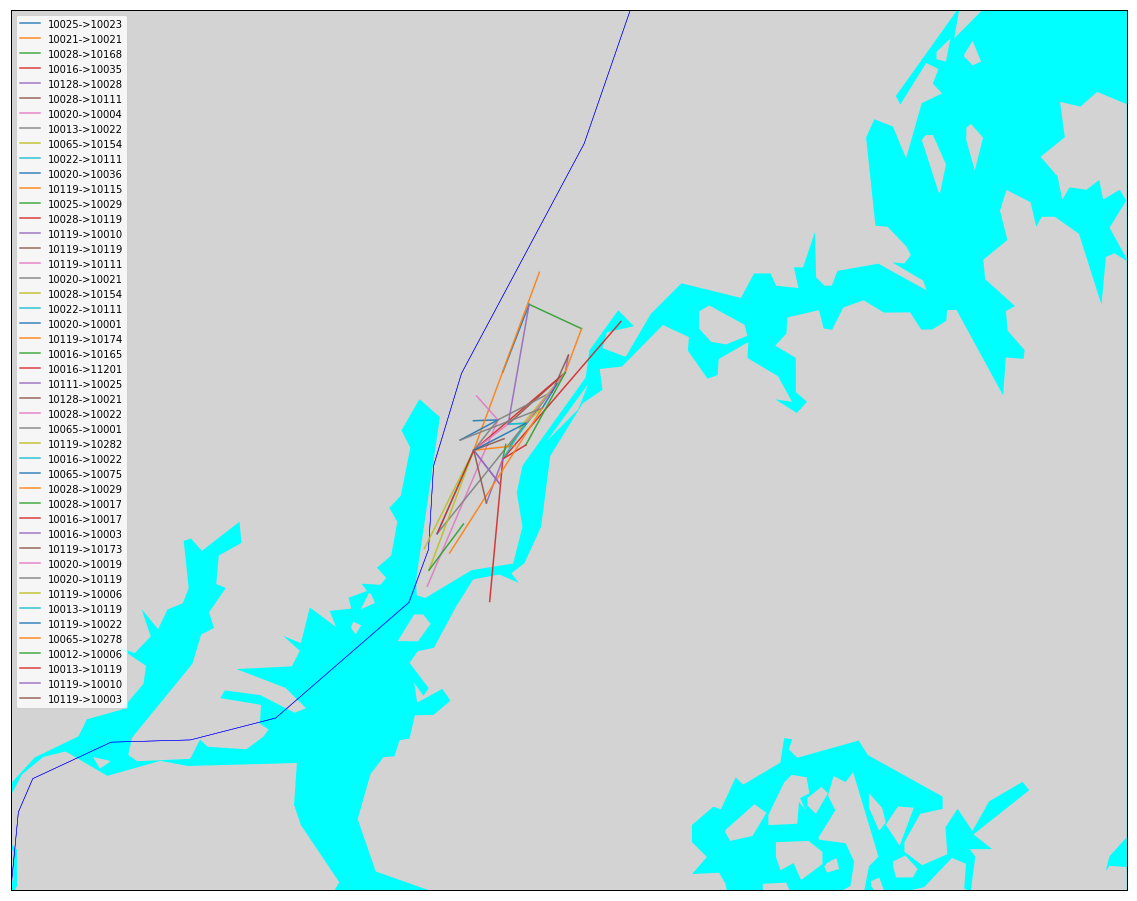

In [304]:
from plotly.offline import init_notebook_mode, iplot
from IPython.display import display, HTML
plt.figure(figsize=(20,20))

# Set the limits of the map to the minimum and maximum coordinates
lat_min = 40.6
lat_max = 40.9
lon_min = -74.2
lon_max = -73.7

# Set the center of the map
cent_lat = (lat_min + lat_max) / 2
cent_lon = (lon_min + lon_max) / 2

map = Basemap(llcrnrlon=lon_min, llcrnrlat=lat_min, urcrnrlon=lon_max, urcrnrlat=lat_max, resolution='h', projection='tmerc', lat_0 = cent_lat, lon_0 = cent_lon, area_thresh = 0.1)

map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='lightgray', lake_color='aqua')
map.drawcountries(linewidth=2)
map.drawstates(color='b')

for trace in testcases[0]['traces']:
    long = []
    lat = []
    start_position = trace['start_position']
    res = findzip.by_zipcode(start_position)
    long.append(res['Longitude'])
    lat.append(res['Latitude'])
    
    destination = trace['destination']
    res = findzip.by_zipcode(destination)
    long.append(res['Longitude'])
    lat.append(res['Latitude'])
    x, y = map(long, lat)
    plt.plot(x, y, '-', label=str(start_position)+'->'+str(destination), markersize=10, alpha=0.9)

# plt.show()
plt.legend()

## Show Animated Traverse on a Particular Driver taces

In [329]:
init_notebook_mode(connected=True)

long = []
lat = []
traces = testcases[0]['traces']
for i in range(len(traces)):
    src = findzip.by_zipcode(traces[i]['start_position'])
    dst = findzip.by_zipcode(traces[i]['destination'])
    long.append({'src':src['Longitude'], 'dst': dst['Longitude']})
    lat.append({'src':src['Latitude'], 'dst': dst['Latitude']})

data = []
frames = []
for i in range(len(lat)):
    x = []
    y = []
    xx = []
    yy = []
    s = []
    new_point = True
    N=5
    if long[i]['src'] == long[i]['dst'] or lat[i]['src'] == lat[i]['dst']:
        x = np.linspace(long[i]['src'], long[i]['dst'], 100)
        y = np.linspace(lat[i]['src'], lat[i]['dst'], 100)

        xx=np.linspace(long[i]['src'], long[i]['dst'],N)
        yy = np.linspace(lat[i]['src'], lat[i]['dst'], 100)
    else:
        x = np.linspace(long[i]['src'], long[i]['dst'], 100)
        m = (lat[i]['src'] - lat[i]['dst'])/(long[i]['src']-long[i]['dst'])
        y = m*(x-long[i]['dst']) + lat[i]['dst']

        xx=np.linspace(long[i]['src'], long[i]['dst'],N)
        yy = m*(xx - long[i]['dst']) + lat[i]['dst']


    data.append(dict(x=x, y=y, 
               mode='lines', 
               line=dict(width=2)
              ))
    data.append(dict(x=x, y=y, 
               mode='lines', 
               line=dict(width=2)
              ))

    color = ''
    for k in range(N):
        if new_point:
            r = lambda: randint(0,255)
            color = '#%02X%02X%02X' % (r(),r(),r())
            new_point = False
        frames.append(dict(data=[dict(x=[xx[k]], 
                            y=[yy[k]], 
                            mode='markers', 
                            marker=dict(color=color, size=15)
                            )
                      ])) 
lat_min = 40.65
lat_max = 40.85
lon_min = -74.1
lon_max = -73.8
layout=dict(xaxis=dict(range=[lon_min, lon_max], autorange=False, zeroline=False),
            yaxis=dict(range=[lat_min, lat_max], autorange=False, zeroline=False),
            title='Traces for Taxi in a Particular Day', hovermode='closest',
            updatemenus= [{'type': 'buttons',
                           'buttons': [{'label': 'Play',
                                        'method': 'animate',
                                        'args': [None]}]}])

figure1=dict(data=data, layout=layout,  frames=frames)          
iplot(figure1, 'points_changing_size'+str(time.time()))

## Compare Historical Income and Proposed Model

In [306]:
result_set = pd.DataFrame(columns=['Roaming Hour', 'Historical Data Income', 'Model Income'])

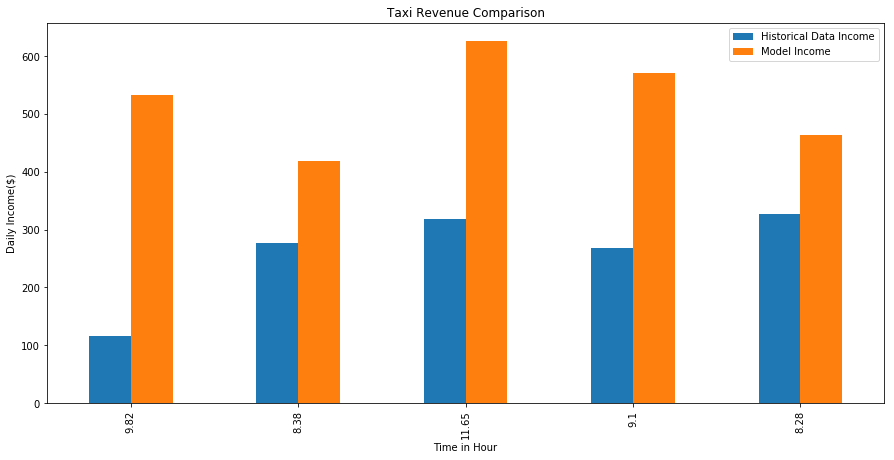

In [325]:
_model_income = []
_hist_income = []
_roaming_hr = []
for testcase in testcases:
    _model_income.append(testcase['income_of_model'])
    _hist_income.append(testcase['income_of_historical_data'])
    _roaming_hr.append(float(("%0.2f"%testcase['hour_spend'])))
    pass
result_set['Model Income'] = _model_income
result_set['Historical Data Income'] = _hist_income
result_set['Roaming Hour'] = _roaming_hr
result_set.plot(kind='bar', x ='Roaming Hour', figsize=(15, 7), title='Taxi Revenue Comparison', legend =True)
plt.ylabel('Daily Income($)')
plt.xlabel('Time in Hour')
plt.show()

## Merge Train Data

In [277]:
# train_data1 = pd.read_csv('clean_data.csv')
# train_data2 = pd.read_csv('clean_data_2.csv')
# train_data3 = pd.read_csv('clean_data_3.csv')
# train_data4 = pd.read_csv('clean_data_4.csv')
# train_data5 = pd.read_csv('clean_data_5.csv')
# frames = [train_data1, train_data2, train_data3, train_data4, train_data5]
# result = pd.concat(frames)
# result.to_csv('clean_train_data.csv', index=False)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [278]:
result.shape

(2905906, 38)

In [37]:
# with open('dropPickMap.json', 'w') as fp:
#         json.dump(dropPickMap, fp)
# meanTrip.to_csv('meanTrip.csv', index=False)

## Load Mean Trip and Dropoff Map from Saved File

In [38]:
meanTrip = pd.read_csv('meanTrip.csv')
with open('dropPickMap.json', 'r') as fp:
        dropPickMap = json.load(fp)

In [220]:
with open('testcases.json', 'r') as fp:
        testcases = json.load(fp)

In [330]:
with open('testcases.json', 'w') as fp:
        json.dump(testcases, fp)

In [246]:
len(testcases)

3